# Passive liquidity on order books

Consider a pool consisting of **base asset** $\mathtt{A}$ of quantity $A$, and **quote asset** $\mathtt{B}$ of quantity $B$.

## Xyk pool

The pool follows the invariant:

$$
A \cdot B = K
$$

where $K$ is a constant.

### Mid price

We define the pool's **mid price** $p_{\mathrm{mid}}$ as:

$$
p_{\mathrm{mid}} = - \frac{\mathrm{d} B}{\mathrm{d} A}
$$

Intuitively, $p_{\mathrm{mid}}$ is the ratio of the output quantity of $\mathtt{B}$ if one swaps an infinitesimally small quantity of $\mathtt{A}$ according to the pool's invariant curve.

The pool will place orders on each side of the mid price:

- At prices $p > p_{\mathrm{mid}}$, place **ask** (sell base asset, buy quote asset)
- At prices $p < p_{\mathrm{mid}}$, place **bid** (sell quote asset, buy base asset)

For xyk pools,

$$
p_{\mathrm{mid}} = \frac{B}{A}
$$

### Bids

The pool placing a bid order means the pool wishes to increase its inventory of the base asset and decrease its inventory of the quote asset. This is equivalent to a trader performing a swap against the pool, inputting the base asset and outputting the quote asset.

Consider swapping quantity $a$ of the base asset into quantity $b$ of the quote asset:

$$
A \cdot B = (A + a) (B - b)
$$

Let's define the **price** of this swap as:

$$
p = \frac{b}{a}
$$

We can easily find:

$$
a = -A + \frac{B}{p}
$$

Consider another swap with a different input quantity $a'$ and price $p'$. We can similarly get:

$$
a' = -A + \frac{B}{p'}
$$

The difference in input amounts:

$$
\Delta a = a' - a = B \left( \frac{1}{p'} - \frac{1}{p} \right)
$$

Assume $p$ and $p'$ are two adjacent ticks and $p' < p < p_{\mathrm{mid}}$, this means **the pool will place a bid order of size $\Delta a$ at price $p'$**.

### Asks

Similarly, considering a trader swapping quantity $b$ of the quote asset into quantity $a$ of the base asset.

$$
A \cdot B = (A - a) (B + b)
$$

$$
p = \frac{b}{a}
$$

We find:

$$
a = A - \frac{B}{p}
$$

Consider another swap with output quantity $a'$ and price $p'$, we get:

$$
\Delta a = a' - a = B \left( \frac{1}{p} - \frac{1}{p'} \right)
$$

If $p$ and $p'$ are two adjacent ticks and $p' > p > p_{\mathrm{mid}}$, this means **the pool will place an ask order of size $\Delta a$ at price $p'$**. (Note: order sizes are always measured in the base asset, regardless of bid or ask.)

### Example

Consider a SOL-USD pool (SOL is the base asset; USD is the quote asset) containng 1 SOL and 200 USD, with \\$1 tick size. Pool price $p_{\mathrm{mid}} = \$200$. Let's compute the 20 orders the pool will place in the order book on each side of $p_{\mathrm{mid}}$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reserve of the base asset (SOL)
A = 1
# Reserve of the quote asset (USD)
B = 200
# Tick size
dp = 0.1
# Current pool price
p_mid = B / A

def compute_xyk_bids(num_ticks):
    # Start one tick below p_mid
    p = p_mid - dp
    ps = [p_mid]
    das = [0]
    remaining_a = A

    for _ in range(num_ticks):
        da = B * dp / (p * (p + dp))
        # Stop placing orders if we run out of reserve
        da = min(da, remaining_a)
        ps.append(p)
        das.append(da)
        p -= dp
        remaining_a -= da

    return np.array(ps), np.array(das), np.cumsum(das)

def compute_xyk_asks(num_ticks):
    # Start one tick above p_pool
    p = p_mid + dp
    ps = [p_mid]
    das = [0]
    remaining_b = B

    for _ in range(num_ticks):
        da = B * dp / (p * (p + dp))
        da = min(da, remaining_b / p)
        ps.append(p)
        das.append(da)
        p += dp
        remaining_b -= da * p

    return np.array(ps), np.array(das), np.cumsum(das)

In [3]:
def plot_result(compute_bids, compute_asks, num_ticks=30):
    bid_ps, bid_das, bid_depths = compute_bids(num_ticks)
    ask_ps, ask_das, ask_depths = compute_asks(num_ticks)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    ax1.bar(bid_ps, bid_das, color="green", width=dp * 0.9)
    ax1.bar(ask_ps, ask_das, color="red", width=dp * 0.9)

    ax2.step(bid_ps, bid_depths, color="green")
    ax2.step(ask_ps, ask_depths, color="red")

    ax1.set_ylabel("order size (SOL)")
    ax2.set_ylabel("order depth (SOL)")
    ax2.set_xlabel("price ($)")
    ax2.set_ylim(0)

    plt.tight_layout()
    plt.show()

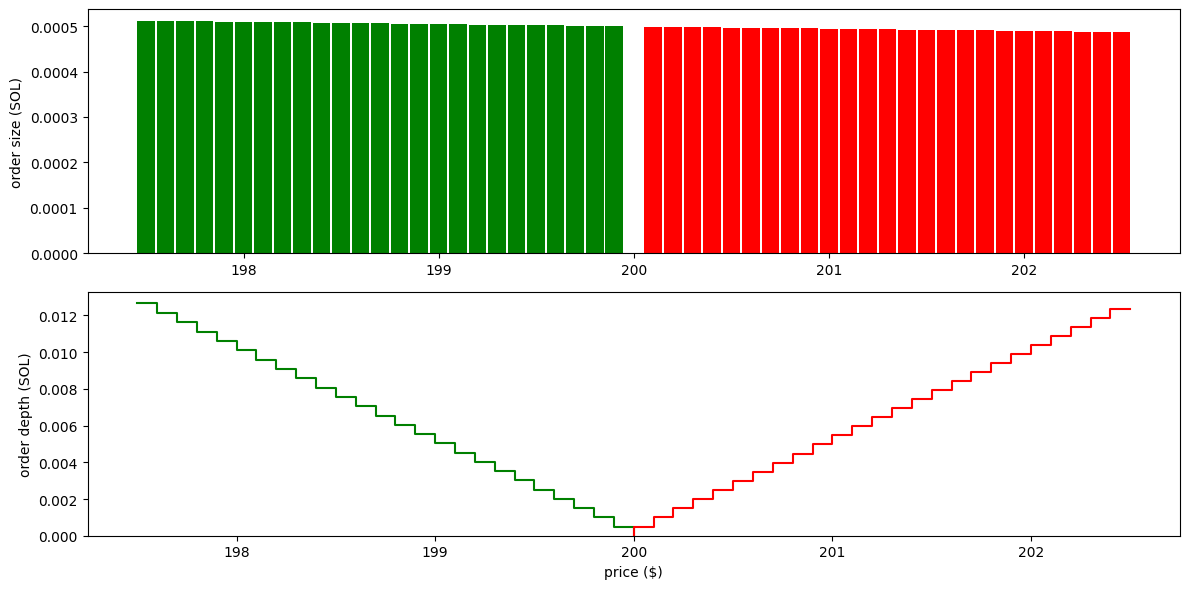

In [4]:
plot_result(compute_xyk_bids, compute_xyk_asks, 25)

As the plot shows, at prices near $p_{\mathrm{pool}}$, liquidity is split roughly evenly across ticks. We prefer a different curve that concentrates liquidity around $p_{\mathrm{pool}}$.

## Solidly pool

The "naive" form of Solidly pool follows the invariant:

$$
A^3 B + A B^3 = K
$$

where $K$ is a constant.

This "naive" invariant assumes the two assets have the same price, which is of course not the case for our SOL-USD example. For such a case, assume we have an external oracle price of $R$ USD per SOL, the invariant can be modified as:

$$
A^3 \left( \frac{B}{R} \right) + A \left( \frac{B}{R} \right)^3 = K
$$

### Mid price

$$
p_{\mathrm{mid}} = - \frac{\mathrm{d} B}{\mathrm{d} A} = \frac{3 R^2 A^2 B + B^3}{R^2 A^3 + 3 A B^2}
$$

In the most common cases, the oracle price $R$ won't equal exactly the mid price. So let's see how they correlate:

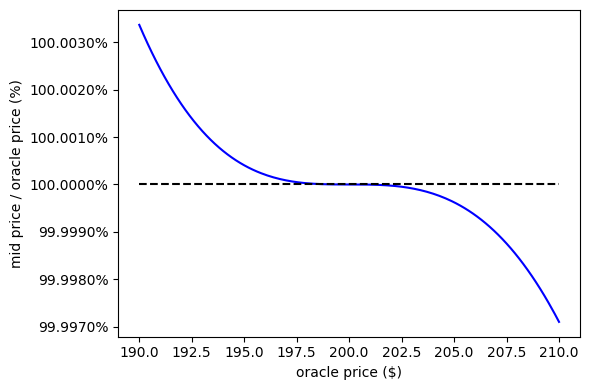

In [5]:
import matplotlib.ticker as mtick

# Reserve of the base asset (SOL)
A = 1
# Reserve of the quote asset (USD)
B = 200

def compute_p_mid(R):
    return (3 * R * R * A * A * B + B * B * B) / (R * R * A * A * A + 3 * A * B * B)

def compute_p_mid_over_R(R):
    return 100 * compute_p_mid(R) / R

Rs = np.arange(190, 210.1, 0.1)
p_mid_over_Rs = np.array(list(map(compute_p_mid_over_R, Rs)))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(Rs, p_mid_over_Rs, color="blue")
ax.plot(Rs, np.full(len(Rs), 100), color="black", linestyle="dashed")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel("mid price / oracle price (%)")
ax.set_xlabel("oracle price ($)")

plt.tight_layout()
plt.show()

As we see, $p_{\mathrm{mid}}$ tracks $R$ closely, deviating less than 0.003% if $R$ jumps less than 5%. This means the passive liquidity pool is able to adjust its quotes accurately refectly the oracle price, resisting LVR (suppose the oracle price updates fast enough).

### Bids

Consider at price $p < p_{\mathrm{mid}}$, a trader swaps $a$ units of the base asset at price into $p \cdot a$ units of quote asset:

$$
K = A^3 \left( \frac{B}{R} \right) + A \left( \frac{B}{R} \right)^3
$$

$$
\alpha = A + a
$$

$$
\beta = \frac{B - pa}{R}
$$

$$
f(a) = \alpha^3 \beta + \alpha \beta^3 - K = 0
$$

This is a 4th-degree polynomial function, so finding an exactly solution is not feasible. Instead, we use **Newton's method**.

- choose an initial value $a_0 \ne 0$
- for $n = 1, 2, 3, \dots$ until converge:
  - $a_n \gets a_{n-1} - \frac{f(a_{n-1})}{f'(a_{n-1})}$

where

$$
f'(a) = - \frac{p}{R} \alpha^3 + 3 \alpha^2 \beta - \frac{3p}{R} \alpha \beta^2 + \beta^3
$$

It's important to choose a non-zero initial value $a_0$, because $a = 0$ is a trivial solution we don't want. Empirically choose $a_0 = A$ always gets us the non-zero solution, but since $A$ is usually big, this can take a lot of iterations before convergence.

### Asks

At the price $p > p_{\mathrm{pool}}$, same as above:

$$
\alpha = A - a
$$

$$
\beta = \frac{B + pa}{R}
$$

$$
f(a) = \alpha^3 \beta + \alpha \beta^3 - K
$$

$$
f'(a) = \frac{p}{R} \alpha^3 - 3 \alpha^2 \beta + \frac{3p}{R} \alpha \beta^2 - \beta^3
$$

In [6]:
# Current oracle price
# Note: try changing this value to slightly above or below 200
R = 200

# Tick size
dp = 0.1

# Current mid price
p_mid = compute_p_mid(R)

# The current invariant value
K = A * A * A * B / R + A * B * B * B / R / R / R

# Note: The math here is very unoptimized.
# Code here is for illustrative purpose, not for production,
# so we choose to stick close to the original math formulae.
def compute_solidly_bid_a(p, tolerance=1e-6, max_iterations=32):
    # Initial value is really important here.
    # A bad initial value can result in getting the trivial solution (zero).
    a_prev = A
    for _ in range(max_iterations):
        alpha = A + a_prev
        beta = (B - p * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = - p * alpha * alpha * alpha / R + 3 * alpha * alpha * beta - 3 * p * alpha * beta * beta / R + beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")

def compute_solidly_bids(num_ticks):
    p = p_mid - dp
    ps = [p_mid]
    das = [0]
    cum_a = 0

    for _ in range(num_ticks):
        a = min(compute_solidly_bid_a(p), A)
        # If we go too much towards the left side, we may get the trivial solutoin (a = 0)
        if a <= 1e-6:
            break;
        da = a - cum_a
        ps.append(p)
        das.append(da)
        p -= dp
        cum_a = a

    return np.array(ps), np.array(das), np.cumsum(das)

def compute_solidly_ask_a(p, tolerance=1e-6, max_iterations=32):
    a_prev = A
    for _ in range(max_iterations):
        alpha = A - a_prev
        beta = (B + p * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = p * alpha * alpha * alpha / R - 3 * alpha * alpha * beta + 3 * p * alpha * beta * beta / R - beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")

def compute_solidly_asks(num_ticks):
    p = p_mid + dp
    ps = [p_mid]
    das = [0]
    cum_a = 0
    remaining_b = B

    for _ in range(num_ticks):
        a = compute_solidly_ask_a(p)
        da = a - cum_a
        da = min(da, remaining_b / p)
        ps.append(p)
        das.append(da)
        p += dp
        remaining_b -= da * p
        cum_a = a

    return np.array(ps), np.array(das), np.cumsum(das)

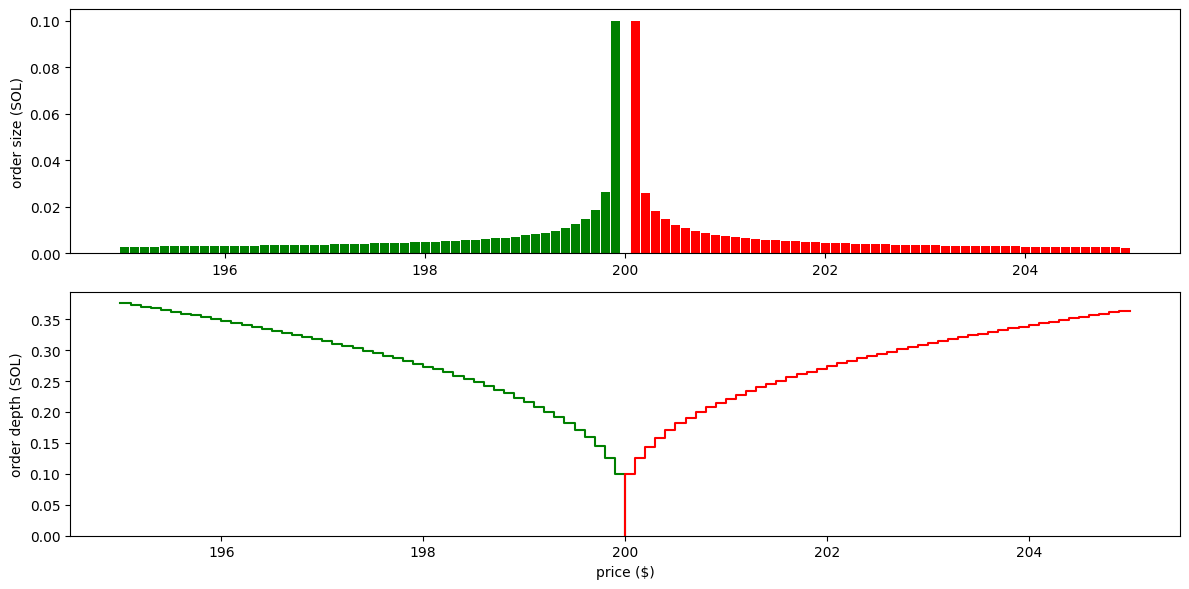

In [7]:
plot_result(compute_solidly_bids, compute_solidly_asks, 50)

As we see, liquidity is indeed a lot more concentrated here.

Let's make the tick size bigger, to see the distribution of liquidity over the whole range of prices. 

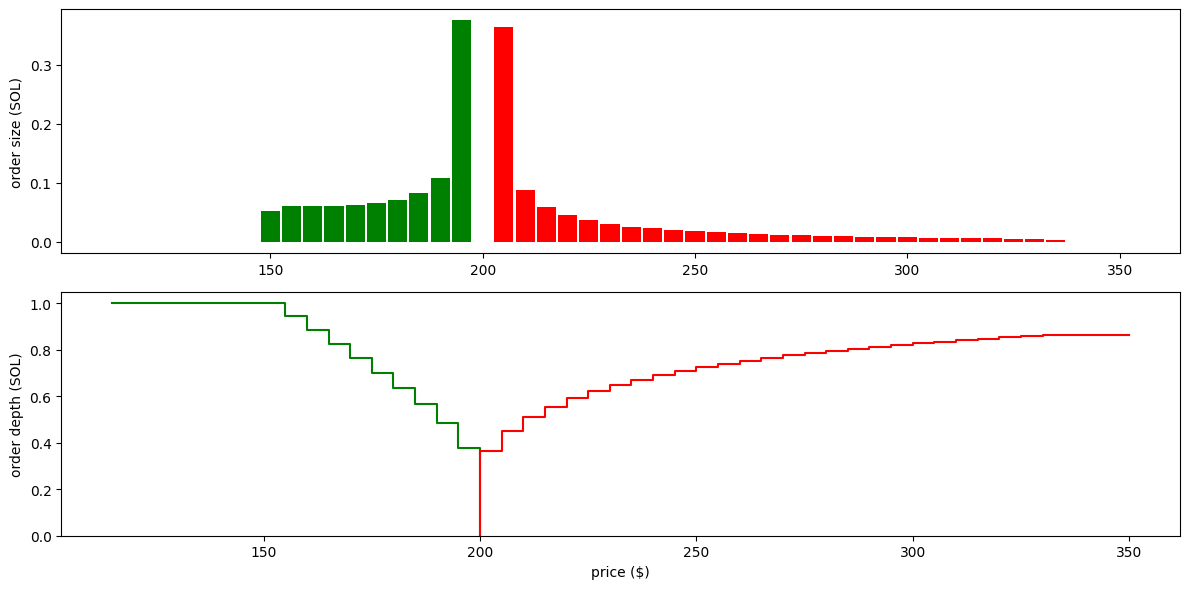

In [8]:
dp = 5

plot_result(compute_solidly_bids, compute_solidly_asks, 30)

## Configurable parameters

We can make the following parameters configurable:

- **Spread**: in the above example, the pool starts placing orders 1 tick away on each side of $p_\mathrm{pool}$, but in some cases a bigger spread may increase profitability.
- **Cadence**: in the above example, the pool places orders every tick. Instead, we can make it only place one order every $N$ ticks.